# Tutorial: Simulation of Information Diffusion in Social Networks 

Online Social Networks (OSNs) are ubiquitious in society and have in many ways transformed the very nature of human communication. They provide a unique opportunity to study human communication behavior and patterns. A particular phenomena of interest is "information diffusion" - that is, how does an idea spread throughout a network? Who are the key players that spread information? Can we predict how this information will continue spreading? 

We present a guide on information diffusion with two parts: 

   1. Building networks and understanding a basic epidemilogical model for information diffusion 
   2. Understanding basic predictive models, such as Linear Threshold and Independent Cascade

# Part 1: Random Networks & Epidemiological Diffusion 



## Introduction 

A cornerstone to understanding information diffusion is investigating different network structures. Because real social networks tend to be huge, random networks are often used in proxy of real data. The first random network was proposed by Erdos and Renyi in 1959. Since then, there has been significant progress in building models that feature more real-world properties. Social networks have two key properties: 
- Scale-Free 
- Community-Oriented 

Scale-Free means that the degrees do not follow any specific distribution; instead, certain nodes can have millions of connections. Community-Oriented means that there exist sub-"clusters" in the graph that have higher-than-average connectivity within the cluster than outside the cluster. 

Two of the leading social network models are the Baradasi-Albert model (which is scale-free) and the Watts-Strogatz network (which displays the clustering properties).

For our purposes, we're going to focus on the scale-free nature of networks. We will work through the following network types: 

1. Erdos-Renyi 
2. Stochastic Block Model 
3. Exponential Distributed Degrees 
4. Power-Law Distributed Degrees 
5. Baradasi-Albert Model 


### Setup 

Before getting started, we need to create the environment and set up some utility functions. This relies on the following non-standard packages: 
  * graph_tool 
  * NumPy 
  * Matplotlib 
  

In [0]:
import graph_tool as gt 
from graph_tool import generation, draw, Graph
import numpy as np
import os 
import copy
#Required to get matplotlib and graph-tool to play nice 
os.environ['KMP_DUPLICATE_LIB_OK']='True' 
import matplotlib.pyplot as plt 
%matplotlib inline 
import random 

l = 0.01 # vary between 0 (no connections) and 1 (all connected) 
n = 1000  # Number of Nodes 
c = 10 # Communities (SBM Only)

# Function used for community networks 
def group_mem_prob(a, b): 
    if a == b: 
        return 0.995 # Increase for tighter communities 
    else: 
        return 0.005 # increase for looser communities 

# Get graph positions using SFDP layouts with common parameters 
def get_positions(graph): 
    pos = draw.sfdp_layout(graph, mu = 1.0, mu_p = 1.0, 
                           gamma=5.0, C= 5.0, p=0.1, max_level=20)
    return pos 

# Draw graph with thin edges and certain properties 
# Optionally specify an output file 
# Must specify to_file=True to get it to work with saving to file.  
def draw_graph(graph, 
               pos = None, 
               to_file = False, 
               vertex_fill_color=None, 
               folder = "", 
               file="graph"): 
    degs = graph.degree_property_map("out")
    degs.a = 2 * np.sqrt(degs.a)
    if pos == None: 
        pos = get_positions(graph) 
    
    if folder != "": 
        path = folder + "/" + file + ".png" 
    else: 
        path = "./" + file + ".png"
    if to_file: 
        draw.graph_draw(graph, output = path, 
                  vertex_size = degs,
                  vertex_fill_color = vertex_fill_color, 
                  pos=pos, edge_color="black", edge_pen_width=0.08)
    else: 
        draw.graph_draw(graph, inline=True, 
            vertex_size = degs,
            vertex_fill_color = vertex_fill_color, 
            pos=pos, edge_color="black", edge_pen_width=0.08)

/Users/rajshrimali/anaconda3/lib/python3.7/site-packages/graph_tool/draw/cairo_draw.py:1494: RuntimeWarning: Error importing Gtk module: No module named 'gi'; GTK+ drawing will not work.
  warnings.warn(msg, RuntimeWarning)


### Erdos-Renyi Graph 

The Erdos-Renyi graph is the simplest of random graphs. For all nodes $n_i, n_j, 0 \le i, j \le N$, an edge is drawn between $n_i$ and $n_j$ with probability $p$. 

Graph-Tool has a convininent method for making a random graph in such a format. We set up our edge probability as a poisson distribution of (n - 1) (other nodes) * (l) (our probability) to get the "mean" degree, and specify the Erdos model for choosing partner nodes. 

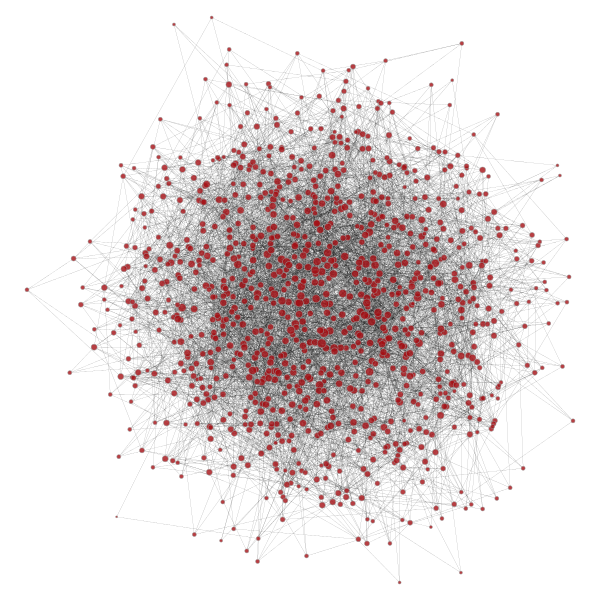

In [0]:
erdos_renyi = generation.random_graph(n, 
                                      lambda: np.random.poisson((n-1) * l), 
                                      directed=False, 
                                      model="erdos") 
draw_graph(erdos_renyi)

### Stochastic Block Model 

A Stochastic Block Model graph displays great community-like characteristics. graph-tool has a way to create these as well, with the parameter $c$ controlling the number of groups. 

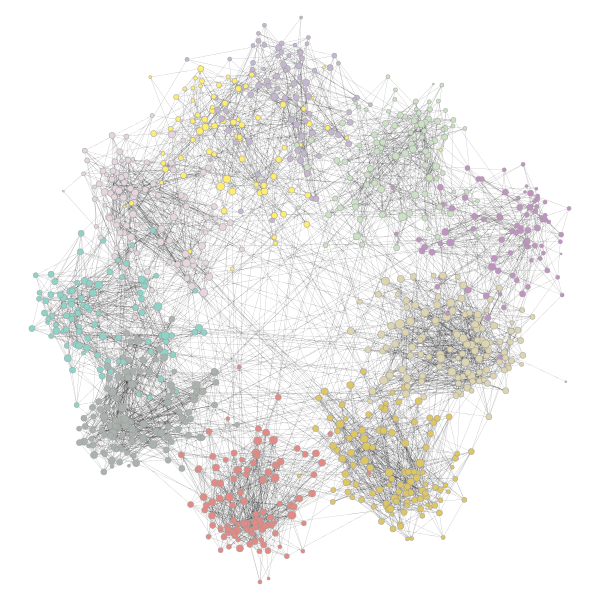

In [0]:
sbm, bm = generation.random_graph(n, lambda: np.random.poisson(c), 
                           directed = False, 
                           model="blockmodel", 
                           block_membership = lambda: np.random.randint(c), 
                           edge_probs = group_mem_prob)
draw_graph(sbm, vertex_fill_color=bm)

### Exponential Distribution 

These are simply created to exhibit a few nodes with a large number of connections, but most with very few. 

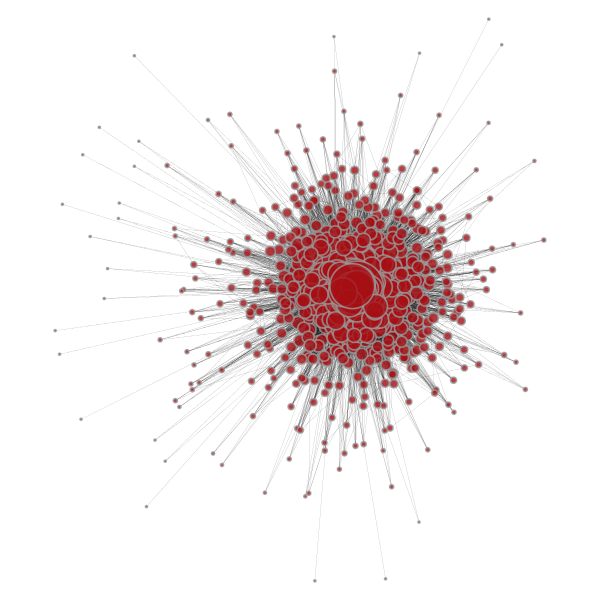

In [0]:
# Exponential Dist. of Degrees 

exp_graph = generation.random_graph(n, 
                lambda: int(np.random.exponential(1/(l))) + 1, 
                directed=False)
draw_graph(exp_graph)

### Watts-Strogatz

The Watts-Strogatz Model exhibits the small-world properties of real-life OSNs

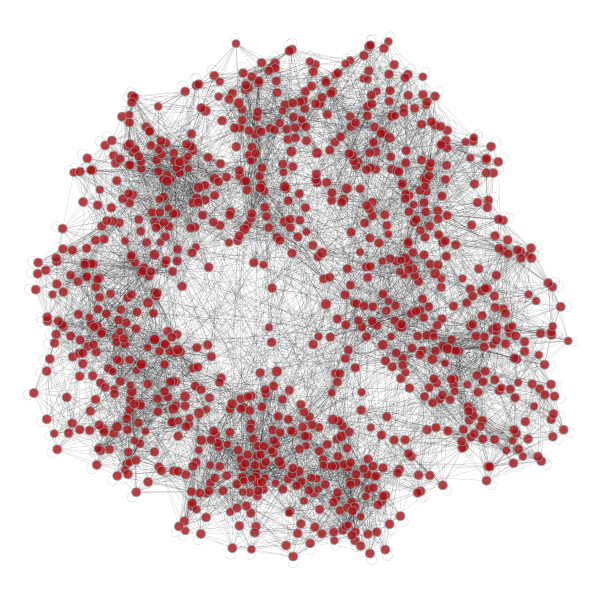

In [0]:
# Creating a Watts-Strogatz graph has the following steps 
# First, create a "ring" over your nodes. Each node is connected to k 
# (in our case, c) nearest neighbors. 
# Shortcut by replacing some edges; for each edge, with probability p, 
# replace it with a new edge with random choie of existing node. 
# generate circular graph first 
watts_strogtaz = generation.circular_graph(n, c, self_loops=True) 
watts_strogtaz.set_fast_edge_removal(True) 
remove_edges = [] 
add_edges = set()
edges = watts_strogtaz.get_edges()
v = None; 
for edge in watts_strogtaz.edges():      
    # with probability l, rewire 
    if random.random() < 0.1: 
        v = watts_strogtaz.vertex_index[edge.source()]
        remove_edges.append(edge) 
        new_neighbor = (random.randint(0, n) + v) % n
        while (v, new_neighbor) in add_edges or (new_neighbor, v) in add_edges: 
            new_neighbor = (random.randint(0, n) + v) % n
        add_edges.add((v, new_neighbor))
for edge in remove_edges: 
    watts_strogtaz.remove_edge(edge) 

watts_strogtaz.set_fast_edge_removal(False) 
watts_strogtaz.add_edge_list(add_edges)

draw_graph(watts_strogtaz)

### Barabasi-Albert Model 

Graph-Tool contains a handy function, ```price_network``` (which is a generalization of Barabasi-Albert) to create a random network. We simply specify the parameter $n$ number of nodes and $m$, the degree of newly added verticies before rewiring. 

The degree-distribution of Barabasi-Albert will also follow a power-law model.

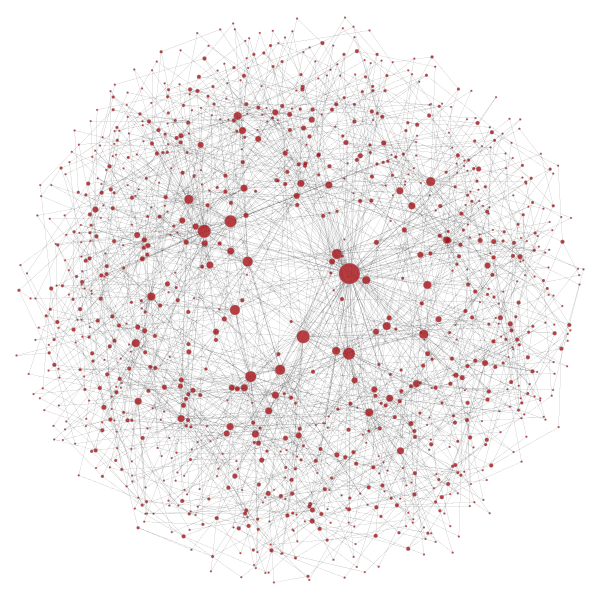

In [0]:
# Barabási–Albert is the go-to for this  
barabasi_albert = generation.price_network(n, m=2, directed=False)
draw_graph(barabasi_albert)

## Epidemiological Spreading



### Background 
A common way to think about information spreading in social networks is through epidemiological parallels. The information is modeled as a disease, and the disease spreads through the network. There are several different epidemiological models
Several Disease-Based Models 
 - SI (Susceptible-Infected) 
 - SIS (Susceptible-Infected-Susceptible) 
 - *SIR  (Susceptible-Infected-Recovered)*
 - **SIRS  (Susceptible-Infected-Recovered-Susceptible)**
 - SEIR (Susceptible-Exposed-Infected-Recovered)
 - S-SEIR 
 - SCIR 
 - irSIR 
 - FSIR 
 - ESIS 

This list is far from exhaustive. The italicized one, SIR, serves as the baseline for most of the more advanced models, while the bolded one, SIRS, is generally considered a more accurate representation of spreading. While the more advanced models each have their nuances tailored to information diffusion in OSNs, we focus on the basic SIRS model for simplicity and demonstrations' sake. 


### SIRS
The SIRS model has three variables. 

  * $s$ is the proportion of individuals susceptible to infection
  * $i$ is the proportion of individuals currently infected
  * $r$ is the proportion of individuals who have recovered and are now immune. 

The model is controlled by three parameters

  * $\lambda$ controls the rate of susceptible individuals becoming infected 
  * $\mu$ controls the rate of infected people recovering 
  * $\alpha$ controls the rate of recovered people becoming susceptible again. 

$$\begin{align} 
    \frac{ds}{dt} &= -\lambda s i + \alpha r\\ 
    \frac{di}{dt} &= \lambda i (1 - i) - \mu i \\ 
    \frac{dr}{dt} &= \mu i - \alpha r 
\end{align}$$

Note that $$s + i + r = 1$$ 

This proportion based model can easily be transformed into a numbers-based model by multiplying everything by $N$. 

To port this model over to a graph, we can do the following: 

For every node, 
1. If a patient is infected
  1. Go over their neighbors. Infect each neighbor with probability $\lambda$ 
  2. Recover them with probability $\mu$ 
2. If a patient is recovered, convert them to susceptible with probability $\alpha$ 


In [0]:
import random 
class SIRS: 
    S = [1, 1, 1, 1] # Susceptible are white 
    I = [0, 0, 0, 1] # Infected are Black 
    R = [0.5, 0.5, 0.5, 1] # Recovered are Grey +
    def __init__(self, graph, *args, **kwargs): 
        ''' 
        Set up the model. Creates an internal copy of the graph, 
        and sets up maps to keep track of our parameters. 
        
        Keep a state reference. 
        '''
        self.g = graph.copy() 
        self.pos = get_positions(self.g) 
        self.lam = self.g.new_edge_property("double") 
        self.mu = self.g.new_vertex_property("double") 
        self.a = self.g.new_vertex_property("double") 
        self.state = self.g.new_vertex_property("vector<double>")
        self.vs = self.g.get_vertices() 
    
    def reset(self, *args, lam = 0.1, mu = 0.05, a = 0.5, infected_patients = [0], **kwargs): 
        ''' 
        Set Lambda, Mu, and Alpha to their starting states. 
        Also, set up which patients are infected. 
        '''
        self.lam.a = lam
        self.mu.a = mu 
        self.a.a = a 
        for v in self.g.vertices(): 
            self.state[v] = SIRS.S 
        for patient in infected_patients: 
            self.state[patient] = SIRS.I 
    
    def infected(self, v): 
        ''' 
        Returns [
            new_susceptible, 
            new_infected, 
            new_recovers 
        ]
        '''
        # try to infect edges 
        new_infects = set() 
        new_recovers = set() 
        for edge in self.g.get_out_edges(v): 
            if self.state[edge[-1]] == SIRS.S: #if they are susceptible... 
                if random.random() < self.lam[self.g.edge(*edge)]: 
                    new_infects.add(edge[-1])
        if random.random() < self.mu[v]: 
            new_recovers.add(v)
        
        return [set(), new_infects, new_recovers]
    def susceptible(self, v): 
        ''' 
        Returns [
            new_susceptible, 
            new_infected, 
            new_recovers 
        ]
        '''
        return [set(), set(), set()]
    def recovered(self, v): 
        ''' 
        Returns [
            new_susceptible, 
            new_infected, 
            new_recovers
        ]
        '''
        new_susceptibles = set() 
        if random.random() < self.a[v]: 
            new_susceptibles.add(v) 
        return [new_susceptibles, set(), set()]

    def step(self): 
        new_infects = set() 
        new_recovers = set() 
        new_susceptibles = set() 
        for v in self.vs: 
            if self.state[v] == SIRS.S: 
                ns, ni, nr = self.susceptible(v) 
                new_infects.update(ni) 
                new_susceptibles.update(ns) 
                new_recovers.update(nr) 
            if self.state[v] == SIRS.I:
                ns, ni, nr = self.infected(v) 
                new_infects.update(ni) 
                new_susceptibles.update(ns) 
                new_recovers.update(nr) 

            # Recover people 
            if self.state[v] == SIRS.R: 
                ns, ni, nr = self.recovered(v) 
                new_infects.update(ni) 
                new_susceptibles.update(ns) 
                new_recovers.update(nr) 

        for v in new_infects: 
            self.state[v] = SIRS.I 
        for v in new_recovers: 
            self.state[v] = SIRS.R 
        for v in new_susceptibles: 
            self.state[v] = SIRS.S 
        return new_susceptibles, new_infects, new_recovers
    
    def run(self, logging_handler, *args, steps = 100, **kwargs): 
        ''' 
        Logging Handler should setup and on a .log() call accept new_suseptible, new_infected, new_recovered. 
        '''
        logging_handler.setup(self.g, steps) 
        for i in range(steps): 
            logging_handler.log(i, *self.step())
    
class LoggingHandler: 
    def setup(self, g, steps): 
        self.g = g 
        self.d = np.zeros((steps, 3)) 
        self.counts = np.zeros((steps, 3)) 
    def log(self, s, new_sus, new_inf, new_rec): 
        self.d[s, 0] = len(new_sus) - len(new_inf)
        self.d[s, 1] = len(new_inf) - len(new_rec)
        self.d[s, 2] = len(new_rec) - len(new_sus)
    
    def plot(self, nodes, initial_infected, title): 
        counts = self.d.cumsum(axis=0) 
        counts[:, 0] += nodes 
        counts[:, 0] -= initial_infected
        counts[:, 1] += initial_infected
        dcounts = self.d 
        
        fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(12, 6), constrained_layout="True") 
        x = list(range(self.d.shape[0])) 
        ax1.plot(x, counts[:, 0], 'b-', label="susceptible")
        ax1.plot(x, counts[:, 1], 'r-', label="infected")
        ax1.plot(x, counts[:, 2], 'g-', label="recovered")
        ax1.legend();
        ax2.plot(x, dcounts[:, 0], 'b--', label='ds')
        ax2.plot(x, dcounts[:, 1], 'r--', label='di')
        ax2.plot(x, dcounts[:, 2], 'g--', label="dr")
        ax2.legend() 

        fig.suptitle(title, fontsize=16)
        ax1.set_title("Total S/I/R Counts") 
        ax1.set_xlabel("Days") 
        ax1.set_ylabel("Count") 

        ax2.set_title("Rates of Change of S/I/R")
        ax2.set_xlabel("Days") 
        ax2.set_ylabel("Rate of Change (People/Day)");
        return fig

In [0]:
# We're ready to run our simulation 
sirs = SIRS(barabasi_albert)
sirs.reset(lam = 0.1, 
           mu = 0.05, 
           a = 0.5, 
           infected_patients = [0]
)
logger = LoggingHandler() 
sirs.run(logger, 100)


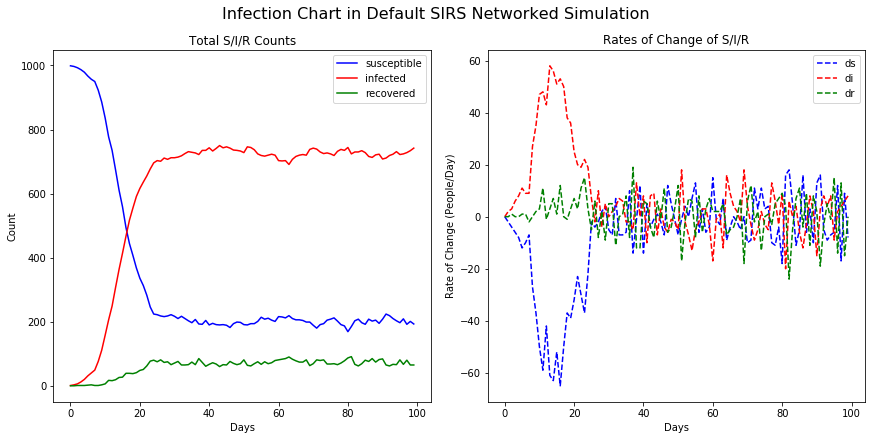

In [0]:
logger.plot(1000, 1, "Infection Chart in Default SIRS Networked Simulation"); 

### Incubated SIRS 

We can easily introduce a slight twist to our model. Now, we modify the step() code. We create an "incubation time" - it takes a certain number of steps before infected individuals can be healed. In the results, we clearly see different behavior! 

In [0]:
class IncubationSIRS(SIRS): 
    ''' SIRS class that has an "incubation time" for infected nodes. 
    Simply overrides the infected method and sets up another state variable. 
    '''
    def __init__(self, *args, **kwargs): 
        super().__init__(*args, **kwargs) 
        self.inc_times = self.g.new_vertex_property("int") 
    
    def infected(self, v): 
        new_sus, new_inf, _ = super().infected(v) 
        # set up incubation time for the new infections 
        for new_i in new_inf: 
            self.inc_times[new_i] = self.new_inc_time
        new_rec = set() 
        # re-do recovering logic 
        if self.inc_times[v] <= 0 and random.random() < self.mu[v]: 
            new_rec.add(v) 
        self.inc_times[v] -= 1 
        return [new_sus, new_inf, new_rec]
    def reset(self, *args, new_inc_time = 14, **kwargs): 
        super().reset(*args, **kwargs) 
        self.new_inc_time = new_inc_time
        for v in self.vs: 
            if self.state[v] == SIRS.I: 
                self.inc_times[v] = self.new_inc_time 
        
inc_sirs = IncubationSIRS(barabasi_albert)
inc_sirs.reset(lam = 0.1, 
           mu = 0.05, 
           a = 0.5, 
           infected_patients = [0], 
         new_inc_time = 14
)
logger = LoggingHandler() 
inc_sirs.run(logger, 100)

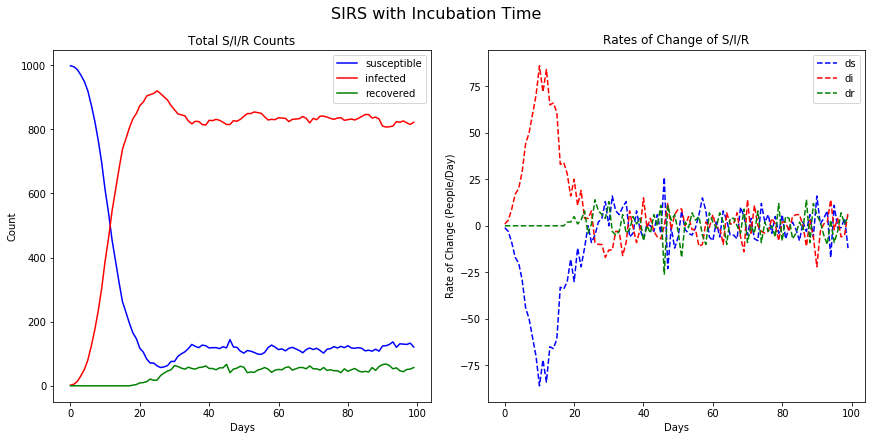

In [0]:
logger.plot(1000, 1, "SIRS with Incubation Time"); 

# Part 2: Predictive Models


### Independent Cascade Model

The independent cascade model is used to describe diffusion of information through a weighted graph network. For a social media network, each person can be considered a node, and edges between people are connections in the social media network (for example, friends on Facebook). Modeling the predicted spread of influence in a social media network allows us to potentially identify several important factors, such as how information will propagate through the network and which nodes are most important in spreading the information. This has many potential applications in advertising and marketing.

When a node becomes active in this model, it is given a single chance to activate each of its currently inactive neighboring nodes. If it fails to do so, then it will not be able to activate that node ever again. The probability of this propagation is defined in the edge between these nodes. If activation of a neighboring node is successful, then the neighbor will become active at the next timestep. This can begin a continuous propagation known as a "cascade."

We start with a small subset of initially active nodes, which are called seed nodes. From here, the network continues propagating for either a set number of steps or until no more nodes can be activated.

#### Independent Cascade

The class-based implementation below allows you to pass in a graph network of your choice, as well as a selection of seed nodes and number of steps. The diffuse method will continue running either for the specified number of steps or until new activation is not possible.

In [0]:
class IndependentCascade:
    def __init__(self, graph, seed_nodes, steps=0):
        for node in seed_nodes:
            if node not in graph.vertices():
                raise Exception(f"Seed node {node} not in graph")
        
        self.g = Graph(graph)
        self.g.set_directed(True)
        self.seed_nodes = seed_nodes
        self.steps = steps

    def diffuse(self):
        """Returns the active nodes of each diffusion step by the independent cascade model

        Parameters
        ----------
        graph: graph_tool graph
        seed_nodes: list of nodes in the graph to start diffusion
        steps: integer for number of steps to run diffusion

        Returns
        -------
        layer_i_nodes: list of list of activated nodes
            layer_i_nodes[0]: seed_nodes
            layer_i_nodes[k]: nodes activated at kth diffusion step
        
        """
        a = [s for s in self.seed_nodes]
        if self.steps <= 0:
            return self._diffuse_all(a)
        return self._diffuse_k_rounds(a, self.steps)

    def _diffuse_all(self, a):
        tried_edges = set()
        layer_i_nodes = []
        layer_i_nodes.append([i for i in a])
        while True:
            len_old = len(a)
            a, activated_nodes, curr_tried_edges = self._diffuse_one_round(a, tried_edges)
            layer_i_nodes.append(activated_nodes)
            tried_edges = tried_edges.union(curr_tried_edges)
            if len(a) == len_old:
                break
        return layer_i_nodes

    def _diffuse_k_rounds(self, a, steps):
        tried_edges = set()
        layer_i_nodes = []
        layer_i_nodes.append([i for i in a])
        while self.steps > 0 and len(a) < len(self.g.nodes()):
            len_old = len(a)
            a, activated_nodes, curr_tried_edges = _diffuse_one_round(self.g, a, tried_edges)
            layer_i_nodes.append(activated_nodes)
            tried_edges = tried_edges.union(curr_tried_edges)
            if len(a) == len_old:
                break
            steps -= 1
        return layer_i_nodes

    def _diffuse_one_round(self, a, tried_edges):
        activated_nodes = set()
        curr_tried_edges = set()
        for node in a:
            for nb in node.out_neighbors():
                if nb in a or (node, nb) in tried_edges or (node, nb) in curr_tried_edges:
                    continue
                if self._prop_success(node, nb):
                    activated_nodes.add(nb)
                curr_tried_edges.add((node, nb))
        activated_nodes = list(activated_nodes)
        a.extend(activated_nodes)
        return a, activated_nodes, curr_tried_edges

    def _prop_success(self, src, dest):
        edge = self.g.edge(src, dest)
        if edge is None:
            return False
        return random.random() <= 0.5

#### Visualizing spread of IC in different networks

We run the information cascade model on the Barabasi-Albert and SBM graphs below. We randomly select 100 seed nodes and run until no more nodes can be activated. Then, observe the graph plots of active and inactive nodes (red and blue, respectively). We can see the activation of cascades based on the probabilities (we chose a universal 0.5 probability of spread).

We can also observe the differences in cascades between the two networks. In the Barabasi-Albert graph, the cascades do not live as long as in the SBM network, likely due to lower connectivity. The SBM graph sees a higher jump in initial activation, and a much higher percentage of the nodes are activated before stopping. The community-oriented nature and higher connectedness of the latter likely play a role in this.

In [0]:
def graph_spread(g):
    activation_probs = g.new_edge_property("double")
    activation_probs.set_value(0.5)
    
    num_seeds = 50
    seed_nodes = random.choices([n for n in g.vertices()], k=num_seeds)
    ic = IndependentCascade(g, seed_nodes)
    layer_i_nodes = ic.diffuse()

    active = g.new_vertex_property("vector<double>")
    for node in g.vertices():
        active[node] = (0,0,1,1)
    for step in layer_i_nodes:
        for node in g.vertices():
            if node in step:
                active[node] = (1,0,0,1)
            # else:
            #     active[node] = (0,0,1,1)
        draw_graph(g, vertex_fill_color=active)

**Barabasi-Albert**

In [0]:
graph_spread(barabasi_albert)

**SBM**

In [0]:
graph_spread(sbm)

#### Volume of Diffusion by Network

We can also compare the volume of activation between different graph types assuming an information cascade model of spread. We run the IC model for each type, with the same number of randomly sampled seeds and identical probabilities of infection, and plot the number of activated nodes over time. The Barabasi-Albert network increases at first, but caps out very quickly. The other networks all see more diffusion before stopping. This is likely because the community-oriented networks offer morer opportunities for a node to infect neighboring nodes in its cluster, which is supported by the SBM and Watts-Strogatz graphs seeing the most activation of new nodes.

/Users/rajshrimali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


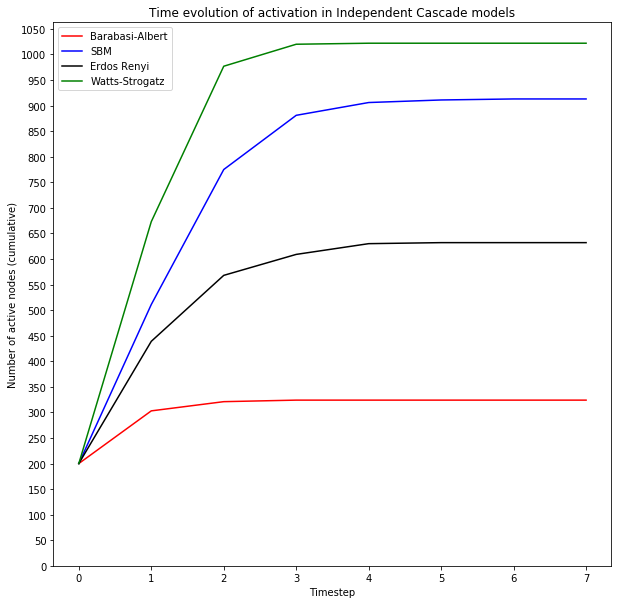

In [0]:
graphs = [barabasi_albert, sbm, erdos_renyi, watts_strogtaz]
graphs_data = []
for gr in graphs:
    g = gr.copy()
    activation_probs = g.new_edge_property("double")
    activation_probs.set_value(0.5)
    num_seeds = 200

    seed_nodes = random.choices([n for n in g.vertices()], k=num_seeds)
    ic = IndependentCascade(g, seed_nodes)
    layer_i_nodes = ic.diffuse()
    total_activated = 0
    actives = []
    for i in layer_i_nodes:
        total_activated += len(i)
        actives.append(total_activated)
    graphs_data.append(actives)

max_len = max([len(x) for x in graphs_data])
for d in graphs_data:
    diff = max_len - len(d)
    while diff > 0:
        d.append(d[len(d)-1])
        diff -= 1

x = np.arange(0, max_len)
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(x, graphs_data[0], c="r")
ax.plot(x, graphs_data[1], c="b")
ax.plot(x, graphs_data[2], c="k")
ax.plot(x, graphs_data[3], c="g")
ax.set_xlabel("Timestep")
ax.set_ylabel("Number of active nodes (cumulative)")
ax.set_yticks(np.arange(0, 5.5*num_seeds, step=50))
ax.set_title("Time evolution of activation in Independent Cascade models")
ax.legend(["Barabasi-Albert", "SBM", "Erdos Renyi", "Watts-Strogatz"])
fig.show()

#### Volume of Diffusion by Number of Seed Nodes

We might also be interested in how the decision of the number of seed nodes affects the diffusion of information. We can observe this by choosing a single graph network at a time and selecting different seed sizes (10, 50, 100, 250). When we run this, we can see that selecting a greater number of seed nodes leads to higher diffusion. This effect is actually present in both networks, suggesting that seed node size affects different networks similarly.

However, what if have a limited number of seed nodes to choose, but want to maximize diffusion? This is an NP-hard problem, and can be further explored in the Influence Maximization section.

In [0]:
def seed_spread(g):
    seeds = [10, 50, 100, 250]
    seeds_data = []
    for s in seeds:
        activation_probs = g.new_edge_property("double")
        activation_probs.set_value(0.5)

        seed_nodes = random.choices([n for n in g.vertices()], k=s)
        ic = IndependentCascade(g, seed_nodes)
        layer_i_nodes = ic.diffuse()
        total_activated = 0
        actives = []
        for i in layer_i_nodes:
            total_activated += len(i)
            actives.append(total_activated)
        seeds_data.append(actives)

    max_len = max([len(x) for x in seeds_data])
    for d in seeds_data:
        diff = max_len - len(d)
        while diff > 0:
            d.append(d[len(d)-1])
            diff -= 1

    x = np.arange(0, max_len)
    fig, ax = plt.subplots(figsize=(10,10))
    ax.plot(x, seeds_data[0], c="r")
    ax.plot(x, seeds_data[1], c="b")
    ax.plot(x, seeds_data[2], c="k")
    ax.plot(x, seeds_data[3], c="g")
    ax.set_xlabel("Timestep")
    ax.set_ylabel("Number of active nodes (cumulative)")
    ax.set_yticks(np.arange(0, 3.5*num_seeds, step=50))
    ax.set_title("Time evolution of activation in Independent Cascade models")
    ax.legend(["10", "50", "100", "250"])
    fig.show()

Barabasi-Albert by Seed Nodes


/Users/rajshrimali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


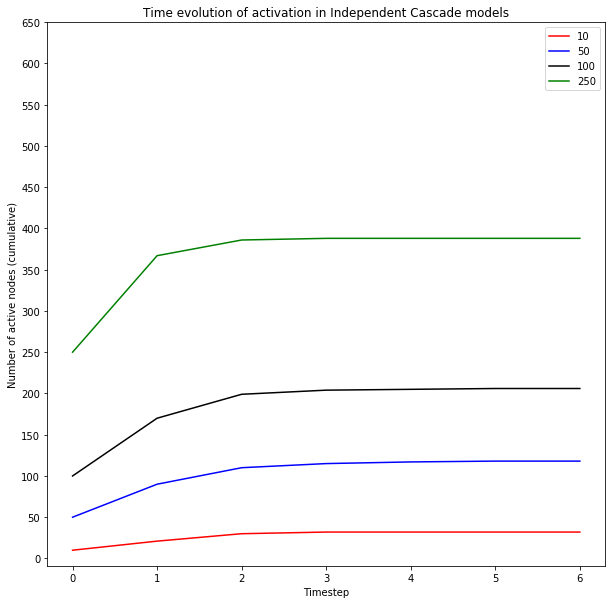

In [0]:
print("Barabasi-Albert by Seed Nodes")
seed_spread(barabasi_albert.copy())

SBM by Seed Nodes


/Users/rajshrimali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


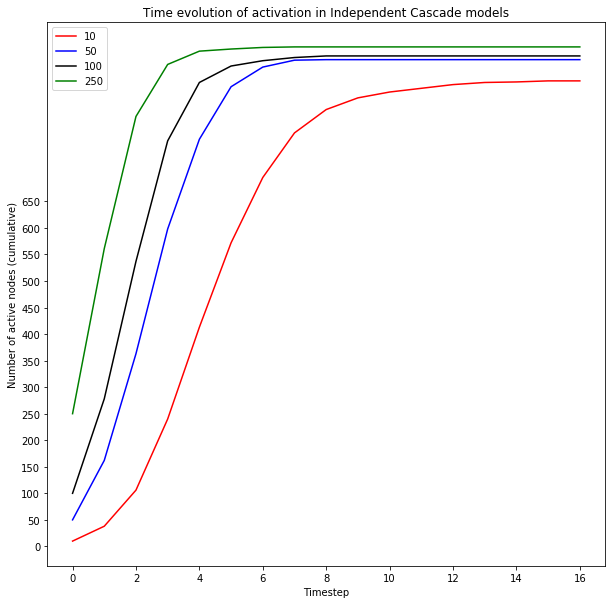

In [0]:
print("SBM by Seed Nodes")
seed_spread(sbm.copy())

### Linear Threshold Model

#### Generalized Threshold

The generalized threshold model is a receiver-centric model, in which a node gets activated only if some function of its neighbors' activations exceeds its own threshold. Mathematically, for a node $v$ with threshold $\theta_v$, if

$$ f(n^{a(t)}(v)) \ge \theta_v$$
 at time t where $n^{a(t)}(v)$ are the neighbors of v that are activated, then at time t+1, v will be an activated node. In the context of threshold models, the term $\it neighbors$ of $v$ refers to the all nodes with edges pointing in to $v$. Furthermore, since it takes only one time step for a node's activation to influence another node's activation, we call the model implemented here $\it synchronous$.

The two main restrictions that f is commonly subjected to are monotonicity and submodularity.

We assume monotonicity for activation. Simply put, once a node is activated, it never becomes deactivated.

Submodularity implies that as the numbers of influential neighbors of v increases, the incremental gain in $f$ decreases. It can be even more briefly summarized as diminishing returns.

Different functions are the basis for different threshold models.


In [0]:
from abc import ABC, abstractmethod
class GeneralizedThreshold(ABC):

    @abstractmethod
    def __init__(self, graph, seed_nodes, thresholds=None, weights=None):
        """Helper for subclasses constructor. Initializes everything as appropriate.
        
        Parameters
        -----------
        graph: graph-tool graph
        seed_nodes: nodes that are first activated
        thresholds: The individual threshold for each node. Passed in as a VertexPropertyMap.
        weights: The weight of each edge in a graph. Passed in as an EdgePropertyMap.
        
        """
        self.g = Graph(graph)
        self.g.set_directed(True)

        # Ensure every node that is initially active belongs to the graph.
        for node in seed_nodes:
            if node not in graph.vertices():
                raise Exception(f"Seed node {node} not in graph")

        self.active_nodes = []
        self.active_nodes.append(seed_nodes) # at time t = 0, only seed nodes are active

        self.thresholds = thresholds
        self.weights = weights

        
            

    
    def set_random_thresholds(self):
        """Helper method for randomly assigning thresholds to nodes """

        thresholds = [random.random() for i in range(self.g.num_vertices())]
        self.thresholds = self.g.new_vertex_property('double', vals=thresholds)
    
    def set_random_weights(self):
        """ Helper method for randomly assigning weights between edges """

        weights = [random.random() for i in range(self.g.num_edges())]
        self.weights = self.g.new_edge_property('double', vals=weights)


    

    def diffuse(self, steps=None):
        """Diffuses information for specified number of steps.
        If steps is not provided, then diffusion happens until no new activation takes place.

        Parameters
        -----------
        steps: The number of steps to diffuse for.

        """

        new_activations = -1 # dummy to start things off

        iteration = 0 # number of steps run so far

        while new_activations != 0:

            if steps is not None and iteration >= steps:
                break
            else:
                iteration += 1
            
            new_activations = 0 # Reset counter for new timestep

            prev_active = self.active_nodes[-1] # Nodes that were active (not activated!!!) at time t-1

            now_active = [] # Nodes that will become active in this timestep

            for node in self.g.vertices():
                if node in prev_active:
                    continue
                elif self.threshold_function(node) >= self.thresholds[node]:
                    now_active.append(node)
            
            new_activations = len(now_active)

            for prev in prev_active:
                now_active.append(prev)
            
            self.active_nodes.append(now_active)
        

        # Extend active nodes for desired number of steps if activation has already acquiesced
        if steps is not None and iteration < steps:
            for i in range(iteration, steps):
                self.active_nodes.append(self.active_nodes[-1])

    

    def plot_activations(self):
        """ Helper function for plotting time evolution of activation"""

        num_activations = [len(activated) for activated in self.active_nodes]

        fig, ax = plt.subplots(figsize=(10,10))
        ax.scatter(np.arange(0, len(num_activations)), num_activations)
        ax.set_xlabel("Timestep")
        ax.set_ylabel("Number of Active Nodes")
        ax.set_title("Time evolution of activation in network")
        fig.show()

    
    def get_activated_nodes(self):
        return self.active_nodes



                

    @abstractmethod
    def threshold_function(self, node):
        pass





#### Linear Threshold

The Linear Threshold model works on the principle that a node is activated if the weighted sum of the activations of its neighbors exceeds its own unique threshold. For a node $v$, with a threshold $\theta_v$, if $\Sigma_{u \in n^a(v)} w_{u,v} \ge \theta_v$ at time t where $n^a(v)$ are the neighbors of v that are activated, then at time t+1, v will be an activated node.

One of the benefits of the Linear Threshold is that it is simple and reasonably reflective of reality. Individuals are influenced by those around them. Each individual may have a different degree of susceptibility to influence. And more importantly, each individual generally has people who they trust or are influenced more by. The weighted sum of all neighbors captures this essence.

Linear Threshold is the most commonly implemented predictive model alongside the Independent Cascade model. The independent cascade model is sender-centric (i.e. diffusion is from the perspective of the node already activated). The Linear Threshold model is receiver-centric (i.e. node currently inactive but has the potential to be activated). Furthermore, in the independent cascade model, each node only gets one shot at activating its neighbors. However, in the Linear Threshold model, an active node can play a part in activating its neighbor at any timestep.


In [0]:
class LinearThreshold(GeneralizedThreshold):

    def __init__(self, graph, seed_nodes, thresholds=None, weights=None):
        """ Constructor for LT.
        Randomly assigns thresholds and weights if none are provided
        """
        super().__init__(graph, seed_nodes, thresholds, weights)

        if thresholds is None:
            super().set_random_thresholds()
        
        if weights is None:
            super().set_random_weights()

    


    def threshold_function(self, node):
        """ The threshold function for the Linear Threshold model.

        Parameters
        ----------
        node: The node for which the activation is being calculated

        Returns
        --------
        normalized: An activation value between 0 and 1 that will be compared against the threshold of the node
        """

        active_neighbors = [neighbor for neighbor in node.in_neighbors() if neighbor in self.active_nodes[-1]]

        total = [self.weights[edge] for edge in node.in_edges()]
        total = sum(total) # total weight of neighbors

        if total == 0:
            return 0

        activation = 0
        for a in active_neighbors:
            activation += self.weights[g.edge(a, node)] # weight of activated neighbors

        
        # Normalize activation
        normalized = activation / total
        return normalized
            




#### Majority Threshold

What if an individual only adopts a new product (aka becomes activated) only if half or more of his connections adopt the product. This is the basis for the majority threshold in which the threshold for every node is uniformly set to be 0.5. The threshold function calculates the number of active neighbors and normalizes it using the total number of neighbors.

In [0]:
class MajorityThreshold(GeneralizedThreshold):

    def __init__(self, graph, seed_nodes, thresholds=None, weights=None):
        super().__init__(graph, seed_nodes, thresholds, weights)

        self.thresholds = self.g.new_vertex_property('double', val=0.5)

    
    def threshold_function(self, node):
        num_active_neighbors = 0
        neighbors = node.in_neighbors()
        if node.in_degree() == 0:
            return 0
        else:
            for neighbor in neighbors:
                if neighbor in self.active_nodes[-1]:
                    num_active_neighbors += 1
            
            return num_active_neighbors / node.in_degree()


#### Unanimous Threshold

A unanimous threshold is an even more specific case where a user only adopts a piece of information if ALL of his neighbors have adopted it.

In [0]:
class UnanimousThreshold(GeneralizedThreshold):

    def __init__(self, graph, seed_nodes, thresholds=None, weights=None):
        super().__init__(graph, seed_nodes, thresholds, weights)

        self.thresholds = self.g.new_vertex_property('double', val=1)
    
    def threshold_function(self, node):
        num_active_neighbors = 0
        neighbors = node.in_neighbors()
        if node.in_degree() == 0:
            return 0
        else:
            for neighbor in neighbors:
                if neighbor in self.active_nodes[-1]:
                    num_active_neighbors += 1
            
            return num_active_neighbors / node.in_degree()
                


#### Testing performance of different threshold models

We want to compare how many total activations each of these models can achieve. We adopt the standard practice of the threshold being sampled from the uniform distribution between 0 and 1. Since the price_network is unweighted, we randomly select the weights in the same way. When testing on a real social network, weights can probably be inferred or learned using the frequency of communication between two nodes.

To test, we randomly select 50 nodes (5% of the nodes in the Barabasi-Albert graph) from the graph to activate. The diffusion then takes place and the results are plotted below.

/Users/rajshrimali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


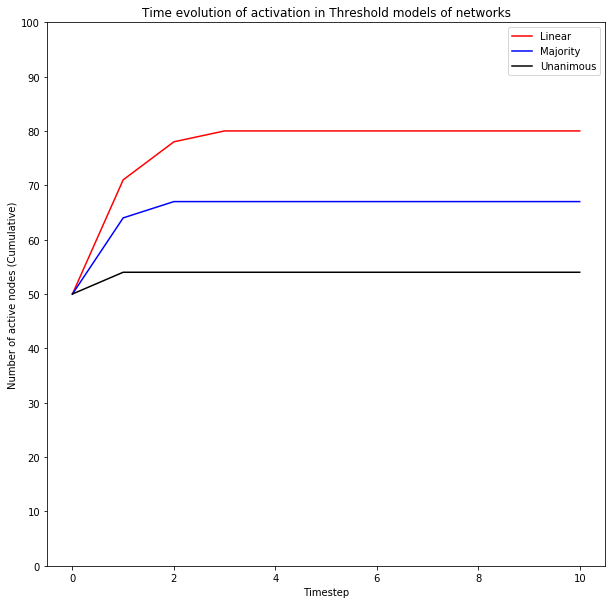

In [0]:
# Creating the graph
g = barabasi_albert.copy()
num_vertices = g.num_vertices() # n = 1000
num_edges = g.num_edges() #1997


num_seeds = 50

seed_nodes = random.choices([n for n in g.vertices()], k=num_seeds)
lt = LinearThreshold(g, seed_nodes)
mt = MajorityThreshold(g, seed_nodes)
ut = UnanimousThreshold(g, seed_nodes)
lt.diffuse(steps=10)
mt.diffuse(steps=10)
ut.diffuse(steps=10)

lt_active = [len(i) for i in lt.get_activated_nodes()]
mt_active = [len(i) for i in mt.get_activated_nodes()]
ut_active = [len(i) for i in ut.get_activated_nodes()]

x = np.arange(0, 11)
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(x, lt_active, c='r')
ax.plot(x, mt_active, c='b')
ax.plot(x, ut_active, c='k')
ax.set_xlabel("Timestep")
ax.set_ylabel("Number of active nodes (Cumulative)")
ax.set_yticks(np.arange(0, 110, step=10))
ax.set_title("Time evolution of activation in Threshold models of networks")
ax.legend(["Linear", "Majority", "Unanimous"])
fig.show()



As can be seen above, the linear threshold is responsible for far more activations than the majority threshold and the unanimous threshold. This makes perfect sense because the majority threshold and unanimous threshold have extremely high requirements for activation.

#### Testing Linear Threshold with uniform weight

So far, we have randomly sampled weights and thresholds from the Uniform distribution between 0 and 1. While it is both a common and sensible practice for the thresholds, there is no particular reason to do so for weights as well. We can set the same weight of 1 for every edge. The weights themselves don't have to be normalized because the implementation normalizes the output of the threshold function. For comparison purposes, the random weight case is also plotted. Since this is highly dependent on the seed nodes, an average number of activations for each timestep after 10 runs is plotted instead.

/Users/rajshrimali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


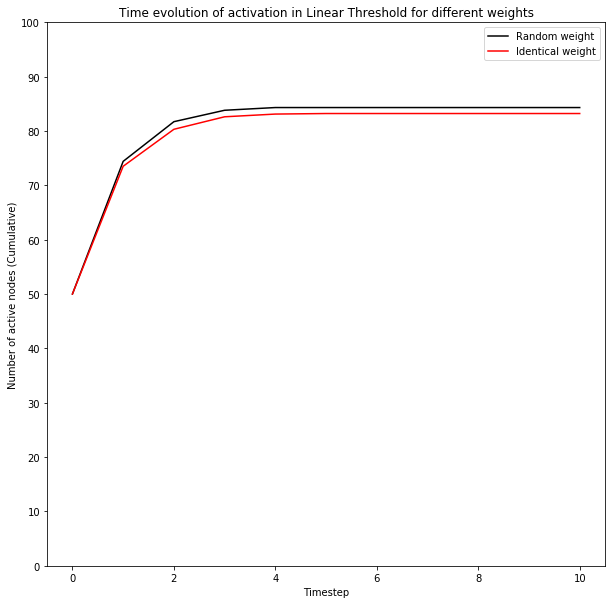

In [0]:
# Creating the graph
g = barabasi_albert.copy()
num_vertices = g.num_vertices() # n = 1000
num_edges = g.num_edges() #1997


num_seeds = 50
random_activations = np.zeros((1,11))
same_weight_activations = np.zeros((1,11))
thresholds = g.new_vertex_property('double', vals=[random.random() for i in range(g.num_vertices())])

for i in range(10):
    seed_nodes = random.choices([n for n in g.vertices()], k=num_seeds)
    lt_random = LinearThreshold(g, seed_nodes, thresholds=thresholds)
    lt_same_weight = LinearThreshold(g, seed_nodes, thresholds=thresholds, weights=g.new_edge_property('double', val=1))

    lt_random.diffuse(steps=10)
    lt_same_weight.diffuse(steps=10)

    lt_random_active = [len(i) for i in lt_random.get_activated_nodes()]
    lt_same_weight_active = [len(i) for i in lt_same_weight.get_activated_nodes()]
    random_activations = np.vstack((random_activations, lt_random_active))
    same_weight_activations = np.vstack((same_weight_activations, lt_same_weight_active))

random_activations = np.delete(random_activations, 0, axis=0)
same_weight_activations = np.delete(same_weight_activations, 0, axis=0)

lt_random_active = np.mean(random_activations, axis=0)
lt_same_weight_active = np.mean(same_weight_activations, axis=0)

x = np.arange(0, 11)
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(x, lt_random_active, c='k')
ax.plot(x, lt_same_weight_active, c='r')
ax.set_xlabel("Timestep")
ax.set_ylabel("Number of active nodes (Cumulative)")
ax.set_yticks(np.arange(0, 110, step=10))
ax.set_title("Time evolution of activation in Linear Threshold for different weights")
ax.legend(["Random weight", "Identical weight"])
fig.show()





#### Testing impact of number of seed nodes in the graph

To observe how the total number of activations may vary with the number of initial nodes, we test the range from 1% (10 nodes) to 10% (100 nodes) of the network being activated. Only the linear threshold model is used for this exercise.

/Users/rajshrimali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


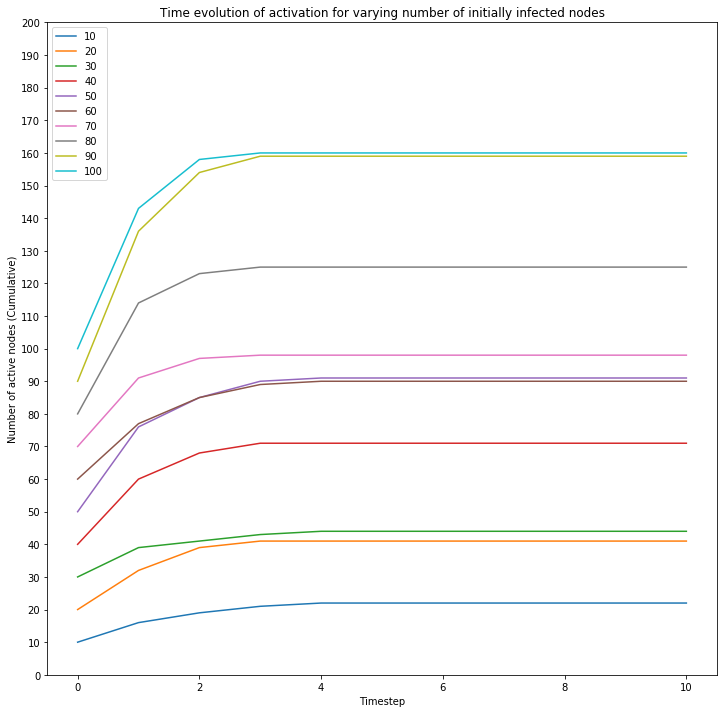

In [0]:
g = barabasi_albert.copy()
num_vertices = g.num_vertices() # n = 1000
num_edges = g.num_edges() #1997

x = np.arange(0, 11)
fig, ax = plt.subplots(figsize=(12,12))

thresholds = g.new_vertex_property('double', vals=[random.random() for i in range(g.num_vertices())])
weights = g.new_edge_property('double',val=1)

num_seeds_range = np.arange(int(num_vertices * 0.01), int(num_vertices * 0.11), step=int(num_vertices / 100))
seed_nodes_i = []
lt_i = []
for i in num_seeds_range:
    seed_nodes = random.choices([n for n in g.vertices()], k=i)
    seed_nodes_i.append(seed_nodes)
    lt = LinearThreshold(g, seed_nodes, thresholds=thresholds, weights=weights)
    lt.diffuse(steps=10)
    lt_i.append([len(i) for i in lt.get_activated_nodes()])
    ax.plot(x, lt_i[-1])



ax.set_xlabel("Timestep")
ax.set_ylabel("Number of active nodes (Cumulative)")
ax.set_yticks(np.arange(0, 210, step=10))
ax.set_title("Time evolution of activation for varying number of initially infected nodes")
ax.legend(num_seeds_range)
fig.show()


As we can notice, the total number of activations definitely increases with the number of initially infected nodes. However, this trivial observation belies the fact that the relative proportion of finally activated nodes to initially activated nodes does not change significantly from 1% to 10%.
This observations explains why the field of $\textbf{Influence Maximization}$ is so important. 

#### Influence Maximization

Influence Maximization is the field of trying to analyze which set of initially activated nodes maximizes the total number of activations in the network. The obvious usecase is marketing. Convincing which group of people is most likely going to lead widespread product adoption is the key question of most marketing campaigns. With fixed budgets, only a limited number of samples maybe distributed. Identifying the target users through influence maximization was the primary motivation behind the development of the predictive models.

We can try to use the Linear Threshold model to perform a simple experiment about which nodes to target.
The first group can be randomly selected.
The second group can be the nodes with the highest out-degree. The reason behind this choice is that these are the nodes that can influence the highest number of nodes in a single timestep. They are given the same weights and thresholds to control for differences that might arise from them.

50 Highest degrees of nodes:  [ 10  10  11  11  11  11  12  12  12  12  13  13  13  13  13  13  13  14
  14  14  14  14  15  15  15  15  15  15  15  16  16  16  17  17  18  19
  20  21  23  24  26  29  29  30  32  36  39  43  45 111]
Average degree of nodes in the graph:  3.994


/Users/rajshrimali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


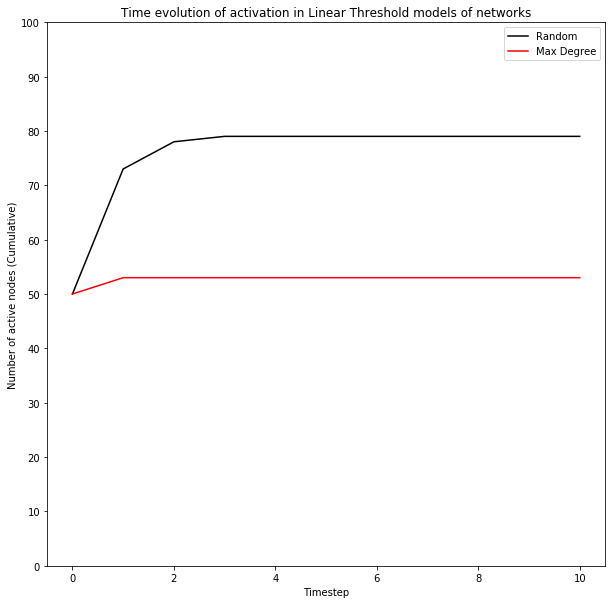

In [0]:
g = barabasi_albert.copy()
num_vertices = g.num_vertices() # n = 1000
num_edges = g.num_edges() #1997


num_seeds = 50
fixed_thresholds = g.new_vertex_property('double', vals=[random.random() for i in range(g.num_vertices())])

seed_nodes_random = random.choices([n for n in g.vertices()], k=num_seeds)
lt_random = LinearThreshold(g, seed_nodes_random, thresholds=fixed_thresholds, weights=g.new_edge_property('double', val=1))

out_degs = g.get_out_degrees(g.get_vertices())
argsorted = np.argsort(out_degs)
degree_sorted = g.get_vertices()[argsorted]
seed_nodes_max_degree = degree_sorted[-50:]
lt_degree = LinearThreshold(g, seed_nodes_max_degree, thresholds=fixed_thresholds, weights=g.new_edge_property('double', val=1))

print("50 Highest degrees of nodes: ", g.get_out_degrees(degree_sorted[-50:]))
print("Average degree of nodes in the graph: ", np.mean(g.get_out_degrees(g.get_vertices())))


lt_random.diffuse(steps=10)
lt_degree.diffuse(steps=10)


lt_random_active = [len(i) for i in lt_random.get_activated_nodes()]
lt_degree_active = [len(i) for i in lt_degree.get_activated_nodes()]


x = np.arange(0, 11)
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(x, lt_random_active, c='k')
ax.plot(x, lt_degree_active, c='r')
ax.set_xlabel("Timestep")
ax.set_ylabel("Number of active nodes (Cumulative)")
ax.set_yticks(np.arange(0, 110, step=10))
ax.set_title("Time evolution of activation in Linear Threshold models of networks")
ax.legend(["Random", "Max Degree"])
fig.show()

As one can notice, simply selecting the nodes with highest degrees does not maximize the spread of activation throughout the network. It does not even perform as well as random selection. One of the problems might be that most of these nodes with high degree are connected to each other, thereby limiting the number of unactivated nodes they can influence. 

Hopefully, this exercise has demonstrated the non-triviality of influence maximization and the importance of predictive models like the Linear Threshold model in experimenting with the influence maximization.

#### Running LT on various networks

/Users/rajshrimali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


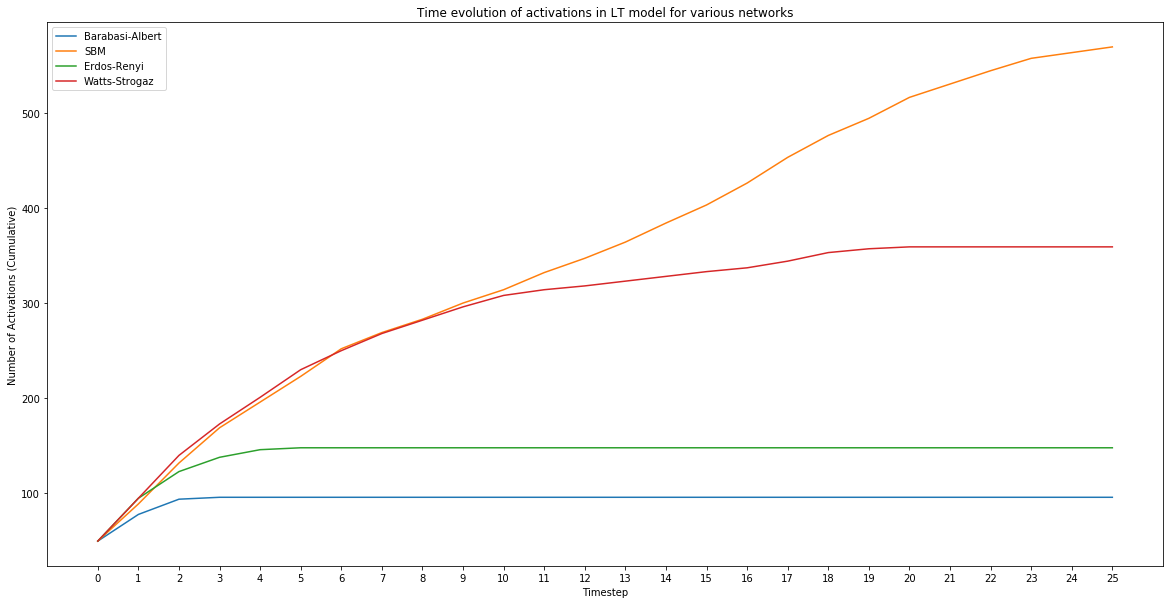

In [0]:
graphs = [barabasi_albert, sbm, erdos_renyi, watts_strogtaz]
graphs_data = []
num_seeds = 50 
num_steps = 25
for gr in graphs:
    g = gr.copy()
    seed_nodes = random.choices([n for n in g.vertices()], k=num_seeds)
    lt = LinearThreshold(g, seed_nodes)
    lt.diffuse(steps=num_steps)
    num_activations = [len(i) for i in lt.get_activated_nodes()]
    graphs_data.append(num_activations)

x = np.arange(0, num_steps + 1, step=1)
fig, ax = plt.subplots(figsize=(20,10))
for d in graphs_data:
    ax.plot(x, d)

ax.set_xlabel("Timestep")
ax.set_ylabel("Number of Activations (Cumulative)")
ax.set_title("Time evolution of activations in LT model for various networks")
ax.set_xticks(np.arange(0,num_steps + 1,step=1))
ax.legend(["Barabasi-Albert","SBM","Erdos-Renyi","Watts-Strogaz"])
fig.show()


As the above plot indicates, running Linear Threshold on the various kinds of graphs shows that SBM has many more activations than Barabasi-Albert. This makes sense because in SBM edges within communities are far more likely than edges between communities. If a handful of nodes in a given community are activated, then, owing to the high density, the rest of the community will get activated. Watts-Strogatz is also a network with high clustering so it is no surprise that the final number of activations is many-fold higher than Barabasi-Albert. Erdos-Renyi is denser than Barabasi-Albert but is not nearly as clustered as SBM or Watts-Strogatz, which explains the activations dying out fairly soon.

#### Running Majority and Unanimous Threshold on various graphs

/Users/rajshrimali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


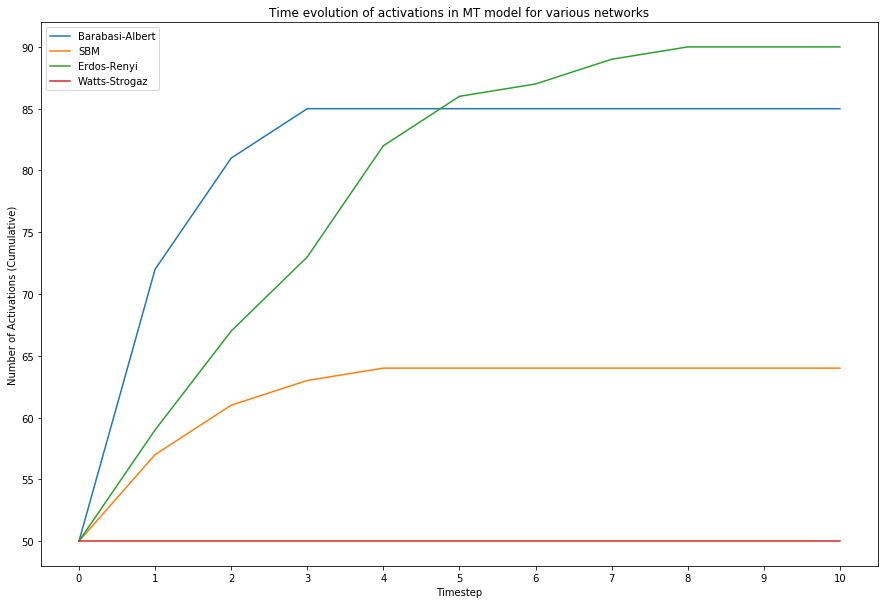

In [0]:
graphs = [barabasi_albert, sbm, erdos_renyi, watts_strogtaz]
graphs_data = []
num_seeds = 50 
num_steps = 10
for gr in graphs:
    g = gr.copy()
    seed_nodes = random.choices([n for n in g.vertices()], k=num_seeds)
    mt = MajorityThreshold(g, seed_nodes)
    mt.diffuse(steps=num_steps)
    num_activations = [len(i) for i in mt.get_activated_nodes()]
    graphs_data.append(num_activations)

x = np.arange(0, num_steps + 1, step=1)
fig, ax = plt.subplots(figsize=(15,10))
for d in graphs_data:
    ax.plot(x, d)

ax.set_xlabel("Timestep")
ax.set_ylabel("Number of Activations (Cumulative)")
ax.set_title("Time evolution of activations in MT model for various networks")
ax.set_xticks(np.arange(0,num_steps + 1,step=1))
ax.legend(["Barabasi-Albert","SBM","Erdos-Renyi","Watts-Strogaz"])
fig.show()


/Users/rajshrimali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


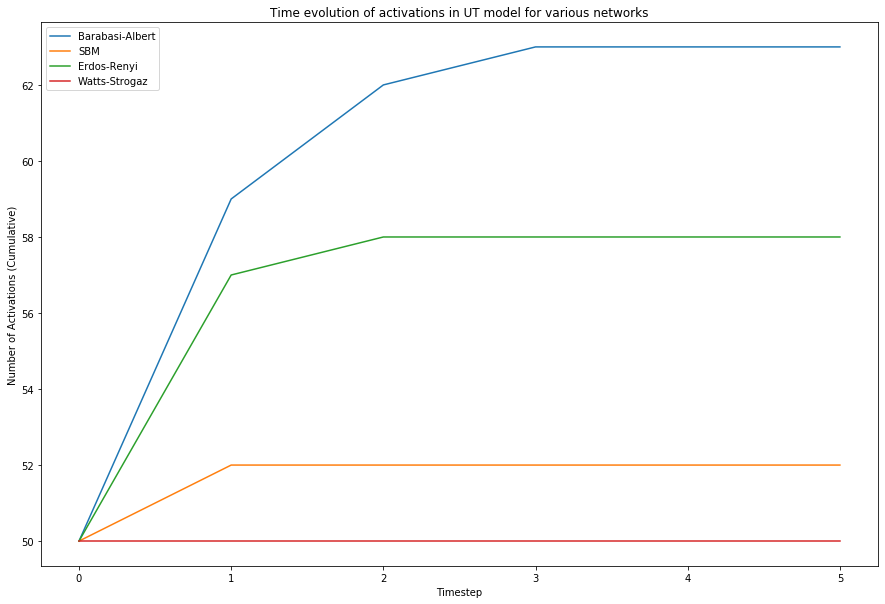

In [0]:
graphs = [barabasi_albert, sbm, erdos_renyi, watts_strogtaz]
graphs_data = []
num_seeds = 50 
num_steps = 5
for gr in graphs:
    g = gr.copy()
    seed_nodes = random.choices([n for n in g.vertices()], k=num_seeds)
    ut = UnanimousThreshold(g, seed_nodes)
    ut.diffuse(steps=num_steps)
    num_activations = [len(i) for i in ut.get_activated_nodes()]
    graphs_data.append(num_activations)

x = np.arange(0, num_steps + 1, step=1)
fig, ax = plt.subplots(figsize=(15,10))
for d in graphs_data:
    ax.plot(x, d)

ax.set_xlabel("Timestep")
ax.set_ylabel("Number of Activations (Cumulative)")
ax.set_title("Time evolution of activations in UT model for various networks")
ax.set_xticks(np.arange(0,num_steps + 1,step=1))
ax.legend(["Barabasi-Albert","SBM","Erdos-Renyi","Watts-Strogaz"])
fig.show()


The above two graphs explain why the linear threshold function is the best in modeling general information diffusion in a social network. Majority and Unanimous thresholds are probably better suited for situations where majority and unanimity are essential features of the system (like voting perhaps). SBM and Watts-Strogatz fail to register any new activations for the unanimous threshold and only a few for the majority threshold. Barabasi-Albert and Erdos-Renyi, on the other hand, diffuse activations better owing to the fact that majority or unanimity may be easy to achieve for nodes with very few connections.

# Work Distribution 

- Raj worked on creating all the random networks and the SIRS simulations. 
- Sidharth built the Independent Cascade model, and tested it with different random graphs. 
- Harsha performed analysis on Linear Threshhold models